# Preprocessing for the Chest X-ray dataset

Dataset originated from the paper of Wang et al. 2016 and extracted from the official NIH source  https://nihcc.app.box.com/v/ChestXray-NIHCC

## Necessary instalations

In [18]:
#!pip install plotly --upgrade --user
#!pip install pandas --upgrade --user
#!pip install numpy --upgrade --user
#!pip install scipy --upgrade --user
#!pip install scikit-learn --upgrade --user
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124 --user
#!pip install holoviews plotly

## Import files for metadata analysis

Get the files of metadata images so that an assesment can be made on the adequate preprocessing in order for the training to be fruitful.

In [9]:
import pandas as pd

#we import the files from our system directly downloaded from the official NIH site
bbox_data = pd.read_csv('Bbox_List_2017.csv', delimiter=',')
metadata = pd.read_csv('Data_Entry_2017_v2020.csv', delimiter=',')

In [10]:
#we output the head of the pandas dataset for the bboxes
display(bbox_data.head())

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


In [11]:
metadata.head(20)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168
6,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,0.143
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168
8,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,0.143
9,00000003_006.png,Hernia,5,3,79,F,PA,2992,2991,0.143,0.143


## Small preprocessing

In [12]:
unique_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',  
                 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule',  
                 'Pleural_Thickening', 'Pneumonia','Pneumothorax']

positive_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',  
                 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening',
                 'Pneumonia','Pneumothorax']

core8_labels = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass',
                'Nodule', 'Pneumonia', 'Pneumothorax']


for label in unique_labels:
    metadata[label] = metadata['Finding Labels'].apply(lambda x: 1 if label in x else 0)

bbox_data = bbox_data.drop(columns=['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'])

In [13]:
bbox_data.rename(columns={"Bbox [x	": "x","h]": "h"})

display(bbox_data.head())

,Image Index,Finding Label,Bbox [x,y,w,h]
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695


In [14]:
display(metadata.head())

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,...,0,0,1,0,0,0,0,0,0,0


## Split the data

Taking into account the consideration of patients of the same ID can't be split within test and train in order to mantain the test as a never seen set of images for the model (images from the same patient look alike and usally share some labels)

In [15]:
from sklearn.model_selection import GroupShuffleSplit

# Get a group shuffle split object with the desired size
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)

# Split the metadata indexes according to the group shuffle
train_idx, test_idx = next(gss.split(metadata, groups=metadata['Patient ID']))

# Create the pandas datasets using 
train_metadata = metadata.iloc[train_idx]
test_metadata = metadata.iloc[test_idx]

# Check the proportions of the resulting splits
print(f"Train set size: {len(train_metadata)}")
print(f"Test set size: {len(test_metadata)}")
print(f"Total set size: {len(train_metadata) + len(test_metadata)}")
print(f"Number of unique patients in train set: {train_metadata['Patient ID'].nunique()}")
print(f"Number of unique patients in test set: {test_metadata['Patient ID'].nunique()}")

Train set size: 89826
Test set size: 22294
Total set size: 112120
Number of unique patients in train set: 24644
Number of unique patients in test set: 6161


## Statistical description of metadata

Here we can see the mean and standard deviation of all variables in order to get an understanding of the numerical properties

In [16]:
# Selecting only the numerical columns
numerical_cols = train_metadata.select_dtypes(include=['int', 'float']).columns.tolist()

# Descriptive statistics for numerical variables
display(train_metadata[numerical_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
Follow-up #,89826.0,8.644268,15.675285,0.000,0.000,3.000,10.000,183.0000
Patient ID,89826.0,14290.180393,8401.086067,1.000,7244.000,13974.500,20524.000,30805.0000
Patient Age,89826.0,46.590853,16.549895,0.000,34.000,49.000,59.000,95.0000
OriginalImage[Width,89826.0,2645.415670,340.591790,1189.000,2500.000,2508.000,2992.000,3550.0000
Height],89826.0,2485.905183,402.170949,966.000,2048.000,2544.000,2991.000,4715.0000
OriginalImagePixelSpacing[x,89826.0,0.155690,0.016136,0.115,0.143,0.143,0.168,0.1988
y],89826.0,0.155690,0.016136,0.115,0.143,0.143,0.168,0.1988
Atelectasis,89826.0,0.104112,0.305408,0.000,0.000,0.000,0.000,1.0000
Cardiomegaly,89826.0,0.024024,0.153125,0.000,0.000,0.000,0.000,1.0000
Consolidation,89826.0,0.041369,0.199143,0.000,0.000,0.000,0.000,1.0000


In [17]:
# Selecting only the categorical columns
categorical_cols = train_metadata.select_dtypes(include='object').columns.tolist()

# Descriptive statistics for categorical variables
display(train_metadata[categorical_cols].describe(include='all').T)

,count,unique,top,freq
Image Index,89826,89826,00000001_000.png,1
Finding Labels,89826,764,No Finding,48373
Patient Gender,89826,2,M,50599
View Position,89826,2,PA,53983


## Correlation analysis

<Axes: >

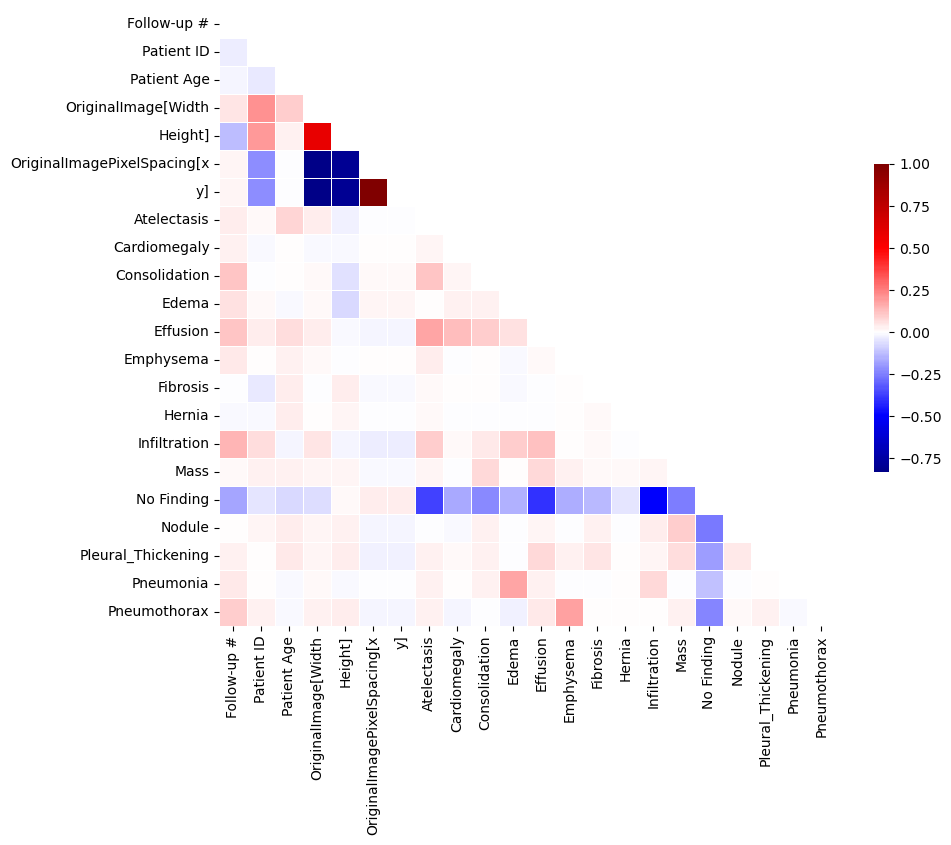

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

corr = train_metadata.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

<Axes: >

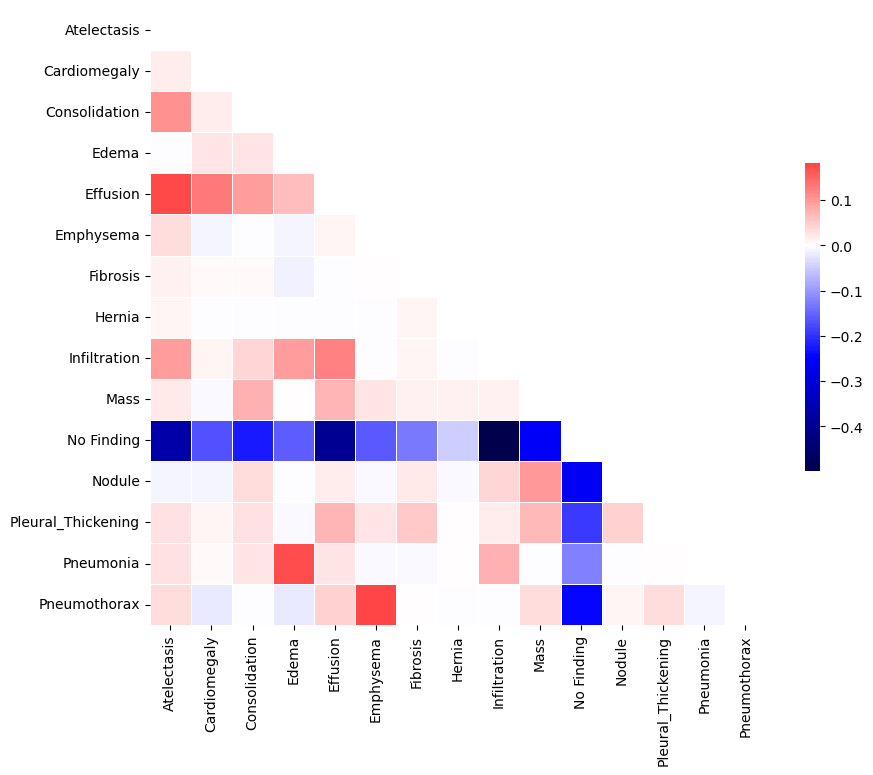

In [19]:
corr2 = train_metadata[unique_labels].corr(numeric_only=True)
mask = np.triu(np.ones_like(corr2, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr2, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Simple visualization

Some simple graphs to understand the distribution and potential trends in data

<Axes: >

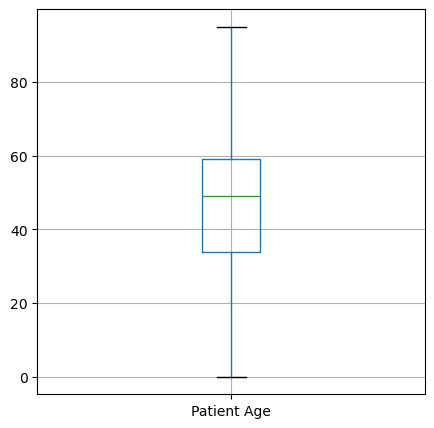

In [27]:
fig, ax = plt.subplots(figsize=(5,5))
data_big = ['Patient Age']
train_metadata[data_big].boxplot()

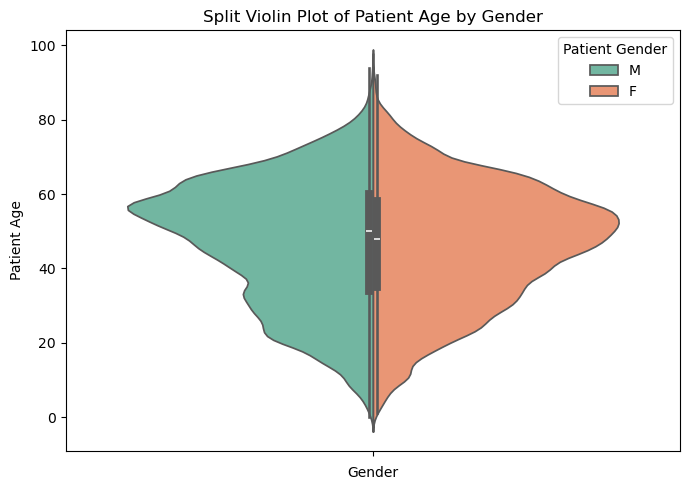

In [34]:
plt.figure(figsize=(7, 5))
sns.violinplot(y='Patient Age', data=train_metadata, hue='Patient Gender', split=True, palette="Set2")
plt.xlabel('Gender')
plt.ylabel('Patient Age')
plt.title('Split Violin Plot of Patient Age by Gender')
plt.tight_layout()
plt.show()

C:\Users\hugoa\AppData\Local\Temp\ipykernel_15324\93597307.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


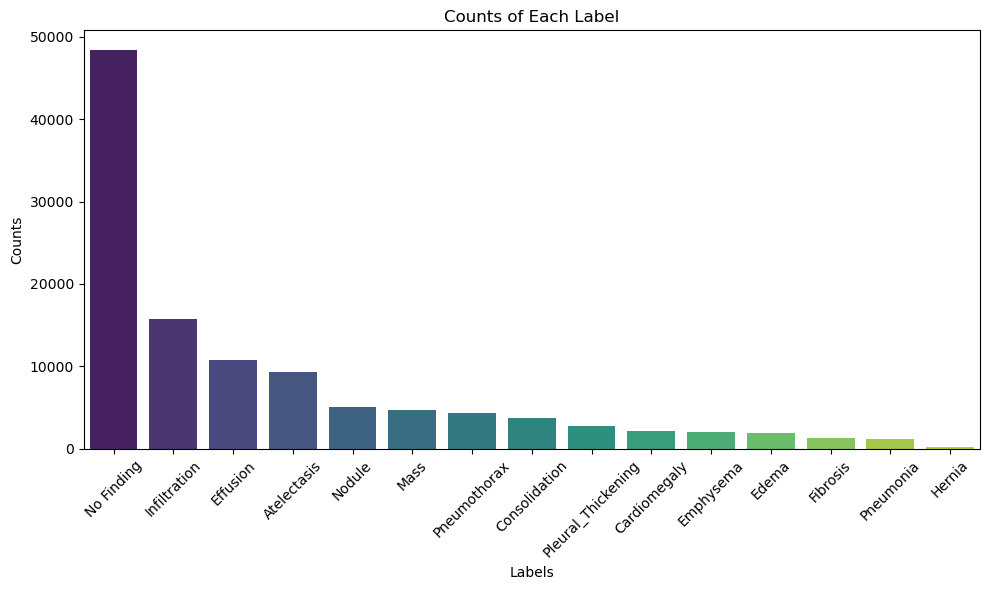

In [21]:
label_counts = train_metadata[unique_labels].sum()

label_counts = label_counts.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")

plt.xticks(rotation=45)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Counts of Each Label')
plt.tight_layout() 

plt.show()

C:\Users\hugoa\AppData\Local\Temp\ipykernel_15324\674496463.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


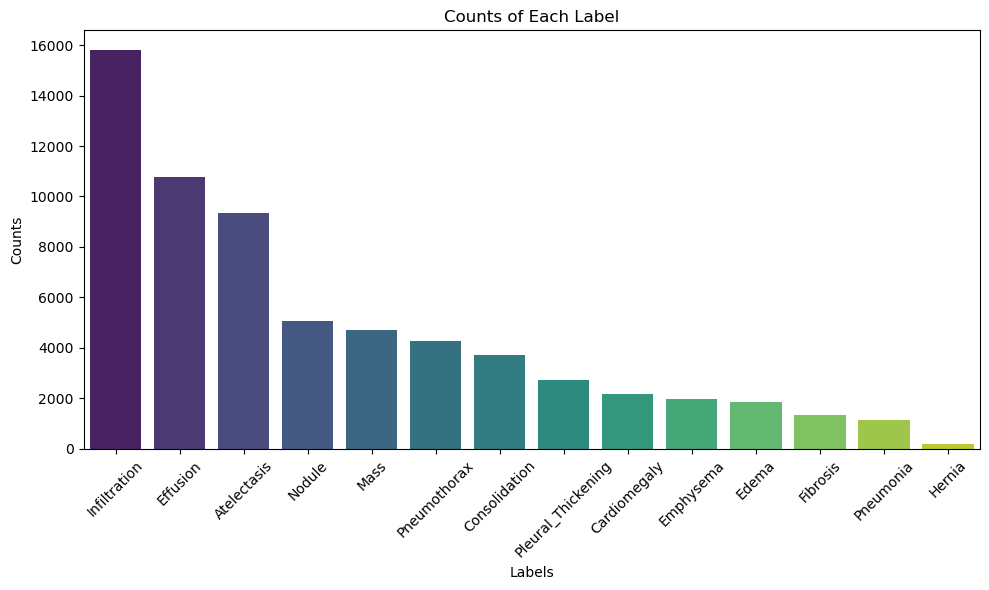

In [22]:
label_counts = train_metadata[positive_labels].sum()

label_counts = label_counts.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")

plt.xticks(rotation=45)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Counts of Each Label')
plt.tight_layout() 

plt.show()

C:\Users\hugoa\AppData\Local\Temp\ipykernel_15324\4048159710.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts_per_patient.index, y=label_counts_per_patient.values, palette="viridis")


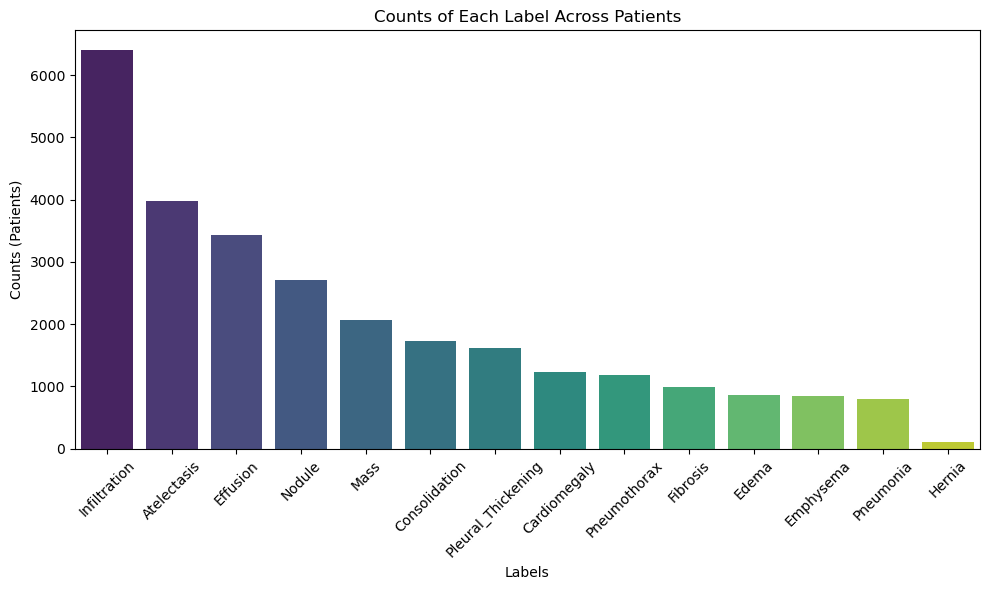

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Group by 'Patient ID' and take the maximum for each label to count each label per patient
patient_label_counts = train_metadata.groupby('Patient ID')[positive_labels].max()

# Step 2: Sum up the number of patients with each label
label_counts_per_patient = patient_label_counts.sum()

# Step 3: Sort the counts in descending order for plotting
label_counts_per_patient = label_counts_per_patient.sort_values(ascending=False)

# Step 4: Plotting the bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=label_counts_per_patient.index, y=label_counts_per_patient.values, palette="viridis")

plt.xticks(rotation=45)
plt.xlabel('Labels')
plt.ylabel('Counts (Patients)')
plt.title('Counts of Each Label Across Patients')
plt.tight_layout() 

plt.show()

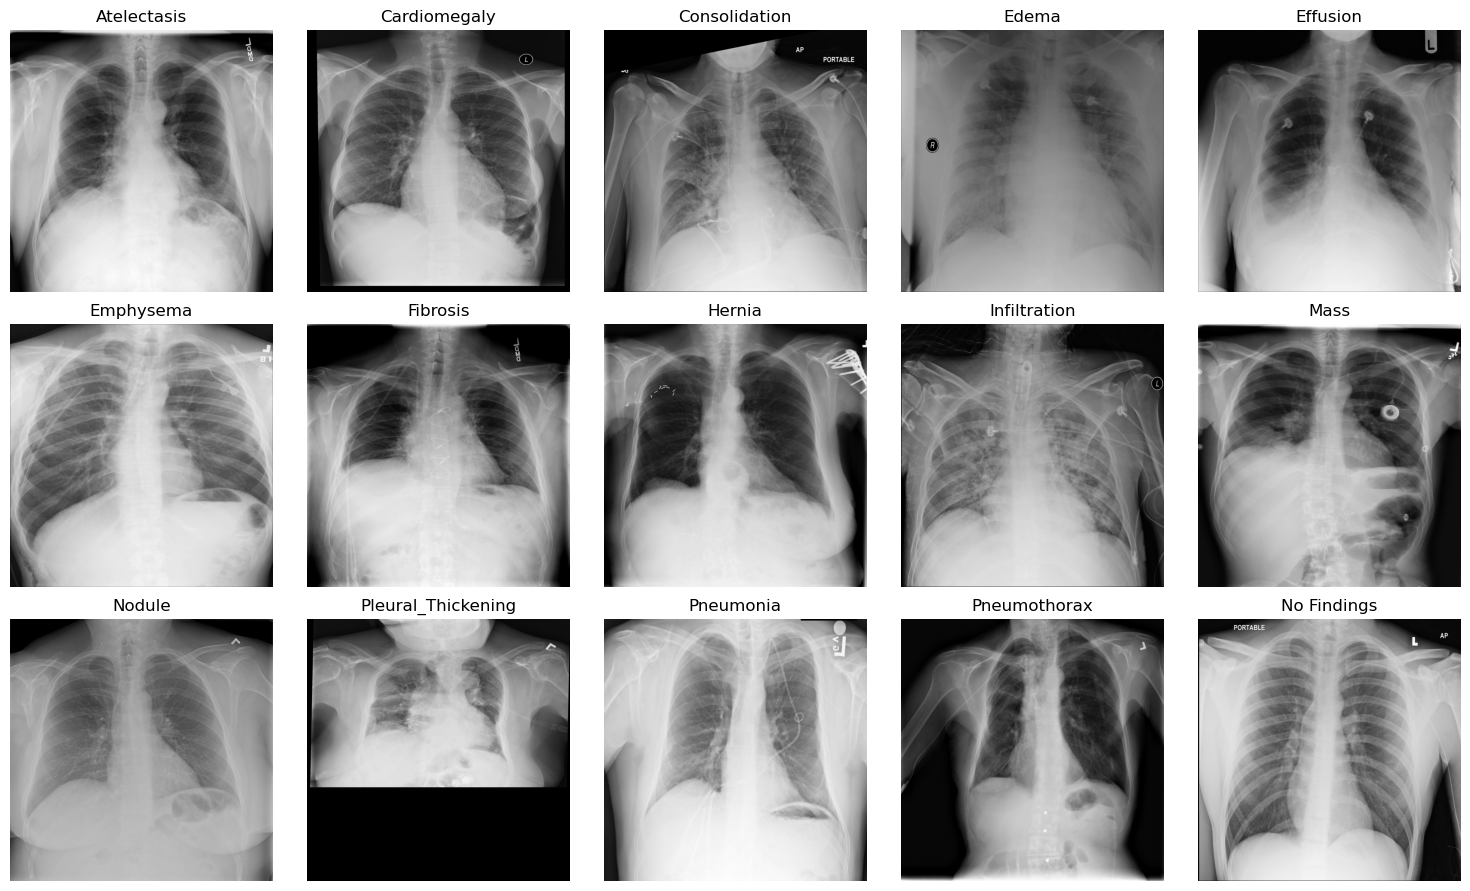

In [54]:
#Full GPT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

# Positive labels as provided
positive_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
                   'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening',
                   'Pneumonia', 'Pneumothorax']

# Assuming 'Image Index' column has the image file names, and they are in the 'images/' folder
image_folder = './images/'

# Filter each label to get cases where only one illness is present (binary 1 for that label, 0 for others)
single_label_images = []

for label in positive_labels:
    # Filter rows where only this label is 1 and all others are 0
    filtered_df = train_metadata[(train_metadata[positive_labels].sum(axis=1) == 1) & (train_metadata[label] == 1)]
    
    # Get the image indices for these rows
    image_indices = filtered_df['Image Index'].values
    
    # If there are any images, select one randomly
    if len(image_indices) > 0:
        chosen_image = random.choice(image_indices)
        single_label_images.append(chosen_image)

# Find an image with no findings (all labels are 0)
no_findings_df = train_metadata[train_metadata[positive_labels].sum(axis=1) == 0]
no_findings_image = None
if len(no_findings_df) > 0:
    no_findings_image = random.choice(no_findings_df['Image Index'].values)

if no_findings_image:
    single_label_images.append(no_findings_image)
    positive_labels.append('No Findings')  # Add this to the labels for title display

# Create a 3x5 grid to display the images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3 rows, 5 columns

# Flatten axes for easier iteration
axes = axes.flatten()

# Load and display the images in a composite (grid) of 15 images
for i, img_index in enumerate(single_label_images):
    # Load the image from the folder
    img_path = os.path.join(image_folder, img_index)
    img = Image.open(img_path)
    
    # Display the image in the grid in grayscale
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(positive_labels[i])
    axes[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

## PCA Analysis of labels

In order to futher understand the possible clusters within the data some PCA analysis will be done to reduce dimensionality of relevant data in order to try and forsee possible trends of the model once trained.

Non-useful variables like id or image size are taken out of the PCA study. Since we are looking for clusters that are related through medical related features like the labels or patients age and gender trying to look for trends.

In [32]:
from sklearn.preprocessing import StandardScaler

train_metadata_pre = train_metadata.copy()

# Non-useful variables like id or image size are taken out of the PCA study
train_metadata_pre = train_metadata_pre.drop(columns=['Image Index', 'Finding Labels', 'Follow-up #',
                                                      'Patient ID', 'View Position', 
                                                      'OriginalImage[Width', 'Height]',
                                                      'OriginalImagePixelSpacing[x', 'y]',])

# The variables selected are related to the medical state of the patient
study_variables =  ['Patient Age','Patient Gender','Atelectasis', 'Cardiomegaly',
                    'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 
                    'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 
                    'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Mild preprocessing is needed to eliminate the last categorical variable
train_metadata_pre['Patient Gender'] = train_metadata_pre['Patient Gender'].map({'M':0, 'F':1})

train_metadata_sd = train_metadata_pre.copy()

sc = StandardScaler()
train_metadata_sd[train_metadata_pre.columns] =  sc.fit_transform(train_metadata_pre)

display(train_metadata_sd.describe().T)

,count,mean,std,min,25%,50%,75%,max
Patient Age,89826.0,2.012358e-16,1.000006,-2.815191,-0.760786,0.145570,0.749806,2.925059
Patient Gender,89826.0,6.739501e-17,1.000006,-0.880484,-0.880484,-0.880484,1.135739,1.135739
Atelectasis,89826.0,2.594550e-17,1.000006,-0.340898,-0.340898,-0.340898,-0.340898,2.933429
Cardiomegaly,89826.0,-9.492255e-18,1.000006,-0.156894,-0.156894,-0.156894,-0.156894,6.373747
Consolidation,89826.0,5.505508e-17,1.000006,-0.207736,-0.207736,-0.207736,-0.207736,4.813810
Edema,89826.0,4.429719e-18,1.000006,-0.144972,-0.144972,-0.144972,-0.144972,6.897888
Effusion,89826.0,-2.974240e-17,1.000006,-0.368980,-0.368980,-0.368980,-0.368980,2.710173
Emphysema,89826.0,-6.201606e-17,1.000006,-0.150325,-0.150325,-0.150325,-0.150325,6.652247
Fibrosis,89826.0,5.062536e-18,1.000006,-0.122218,-0.122218,-0.122218,-0.122218,8.182118
Hernia,89826.0,3.796902e-18,1.000006,-0.044685,-0.044685,-0.044685,-0.044685,22.379035


In [33]:
from sklearn.decomposition import PCA
myPCA = PCA().fit(train_metadata_sd)

print(myPCA.explained_variance_ratio_)
print()
print(myPCA.explained_variance_ratio_.cumsum())

[0.13038201 0.07410205 0.06777823 0.06532567 0.06160565 0.06120141
 0.05921206 0.05837061 0.05758461 0.0557536  0.05490417 0.0517845
 0.04977601 0.04835867 0.04714748 0.04461071 0.01210256]

[0.13038201 0.20448406 0.27226229 0.33758796 0.39919361 0.46039503
 0.51960709 0.5779777  0.63556231 0.6913159  0.74622007 0.79800457
 0.84778059 0.89613926 0.94328673 0.98789744 1.        ]


Text(0.5, 1.0, 'Scree plot')

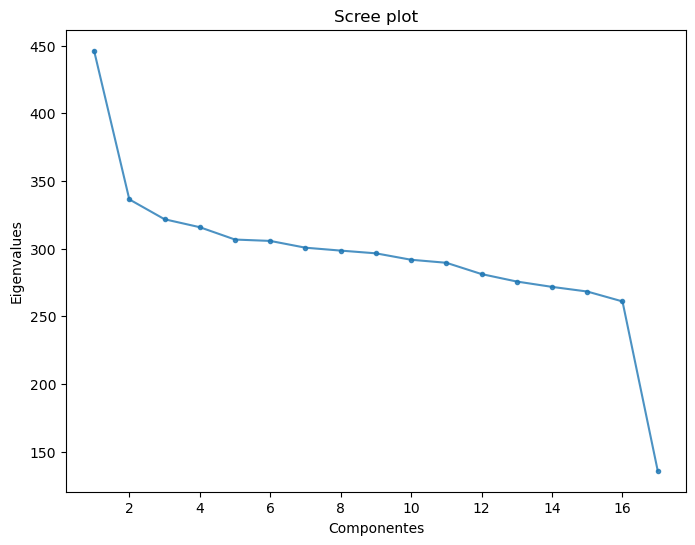

In [18]:
fig = plt.figure(figsize=(8,6))
plt.plot(range(1,len(myPCA.singular_values_ )+1),myPCA.singular_values_ ,alpha=0.8,marker='.')
y_label = plt.ylabel('Eigenvalues')
x_label = plt.xlabel('Componentes')
plt.title('Scree plot')

Text(0.5, 1.0, 'Porcentaje de variancia explicada por componente')

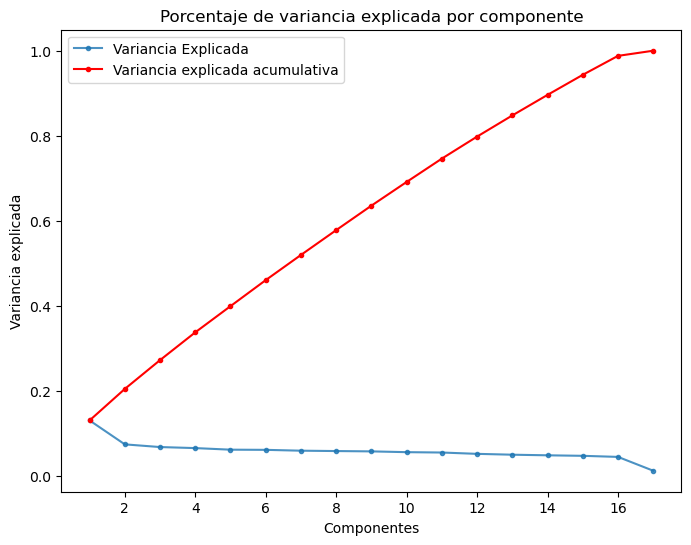

In [19]:
fig = plt.figure(figsize=(8,6))
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada")
y_label = plt.ylabel('Variancia explicada')
x_label = plt.xlabel('Componentes')
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
         np.cumsum(myPCA.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa")
plt.legend()
plt.title('Porcentaje de variancia explicada por componente')

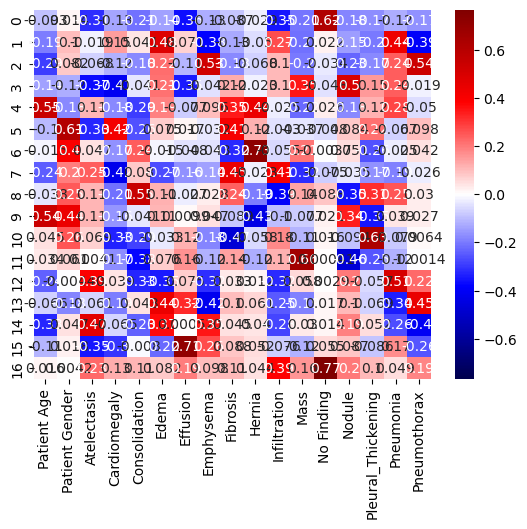

In [20]:
sns.heatmap(myPCA.components_, cmap='seismic',
            xticklabels=list(train_metadata_pre.columns),
            vmin=-np.max(np.abs(myPCA.components_)),
            vmax=np.max(np.abs(myPCA.components_)),
            annot=True);

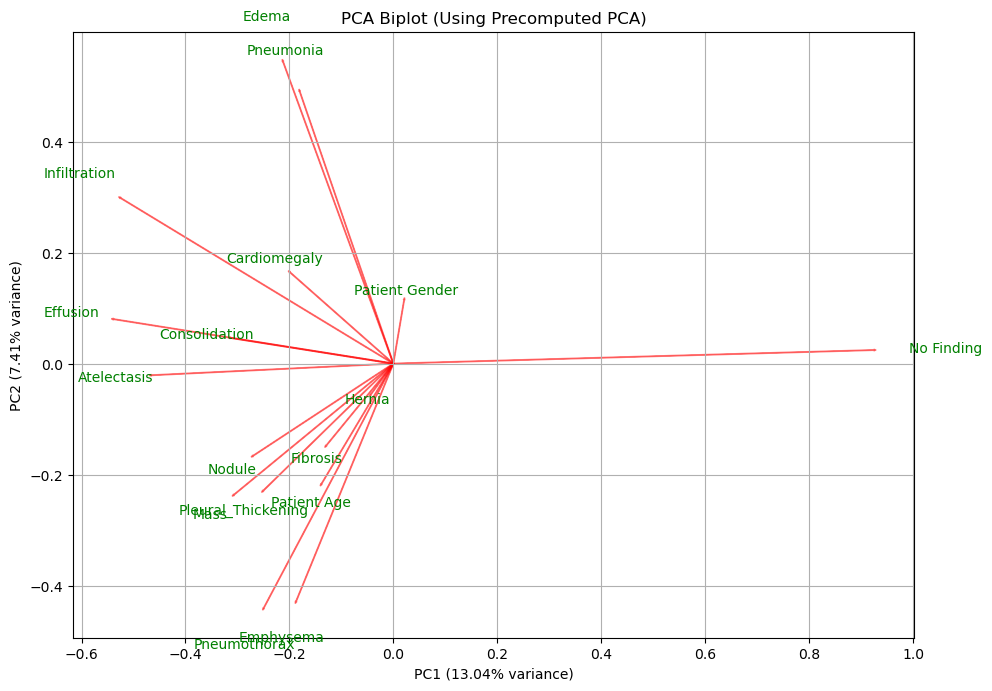

In [21]:
principalComponents = myPCA.transform(train_metadata_sd)

loadings = myPCA.components_[:2].T * np.sqrt(myPCA.explained_variance_[:2])

plt.figure(figsize=(10, 7))

for i, feature in enumerate(train_metadata_sd.columns):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='r', alpha=0.5)
    plt.text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, feature, color='g', ha='center', va='center')

plt.xlabel(f"PC1 ({myPCA.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"PC2 ({myPCA.explained_variance_ratio_[1]:.2%} variance)")
plt.title('PCA Biplot (Using Precomputed PCA)')
plt.grid()

plt.tight_layout()
plt.show()

## t-distributed Stochastic Neighbor Embedding (t-SNE) 

Since PCA assumes that variables can be linearly combined our predominantly one hot encoded dataset holds no real interest since the values are binary instead of contiuous (which usually hold greater lineal combination).

Because of that, t-SNE is a potentially better option since it is a non-linear dimensionality reduction technique since it focuses on preserving the local structure of the data .

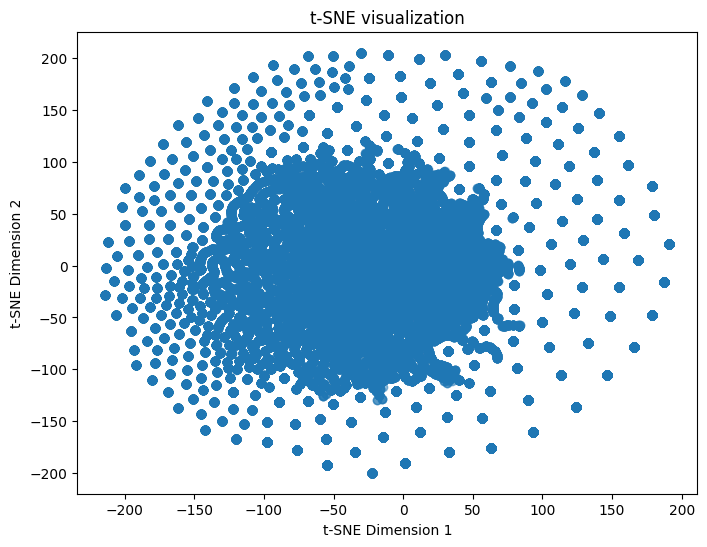

In [94]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(train_metadata_sd)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.title("t-SNE visualization")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

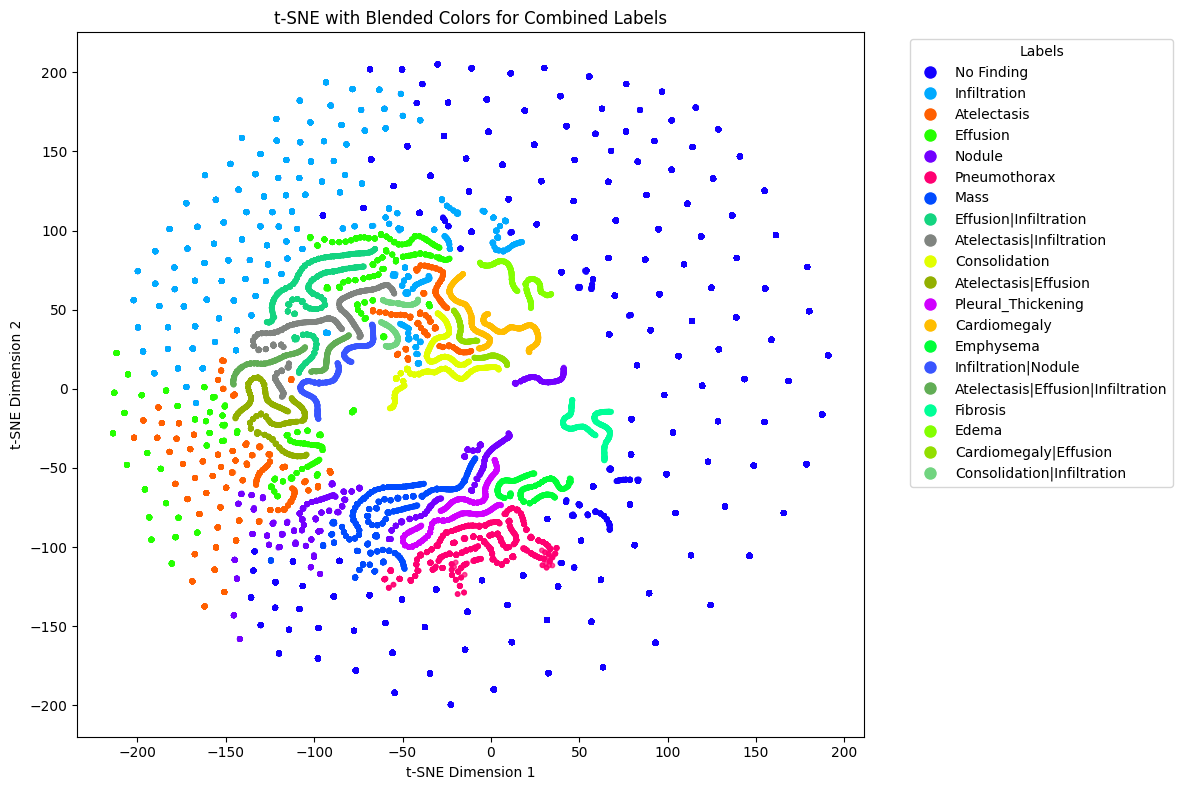

In [195]:
# Base color mapping for individual labels
base_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',  
               'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule',  
               'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Generate a palette for the base labels
palette = sns.color_palette("hsv", len(base_labels))  # Using 'hsv' for distinct but gradient-like colors

# Create a dictionary that maps each base label to a unique color
base_color_mapping = dict(zip(base_labels, palette))

# Function to blend colors for combined labels
def blend_colors(label, base_color_mapping):
    labels = label.split('|')  # Split the combined label into individual labels
    if len(labels) == 1:
        return base_color_mapping[labels[0]]  # Return the single color if it's not a combined label
    
    # Blend the colors for combined labels by averaging their RGB values
    blended_color = np.mean([base_color_mapping[l] for l in labels if l in base_color_mapping], axis=0)
    return blended_color

# Extract combined labels
combined_labels = train_metadata['Finding Labels']

label_counts = combined_labels.value_counts()

top_labels = label_counts.head(20).index


filtered_indices = combined_labels.isin(top_labels)
filtered_labels = combined_labels[filtered_indices]


colors = [blend_colors(label, base_color_mapping) for label in filtered_labels]


def plot_tsne_with_blended_colors(tsne_results, colors, top_labels, title):

    plt.figure(figsize=(12, 8))

    scatter = plt.scatter(tsne_results[filtered_indices, 0], tsne_results[filtered_indices, 1],
                          c=colors, alpha=0.7, s=10)

    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=blend_colors(label, base_color_mapping),
                          markersize=10, label=label) for label in top_labels]
    
    plt.legend(handles=handles, title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.tight_layout()
    plt.show()

plot_tsne_with_blended_colors(tsne_results, colors, top_labels, "t-SNE with Blended Colors for Combined Labels")

## Bounding Box Heatmap

Let's generate a heatmap for each illness using the bbox to gain an understanding on where the pathologies are usually located from humans. This will help in the assesment of the Grad-CAM localization generated

In [34]:
print(bbox_data['Finding Label'].unique())

['Atelectasis' 'Cardiomegaly' 'Effusion' 'Infiltrate' 'Mass' 'Nodule'
 'Pneumonia' 'Pneumothorax']


In [55]:
grid_size = (1024, 1024)

heatmaps = {label: np.zeros(grid_size) for label in core8_labels}

for idx, row in bbox_data.iterrows():
    label = row['Finding Label']
    x = row['Bbox [x']
    y = row['y']
    w = row['w']
    h = row['h]']
    
    # Convert bbox to integer coordinates (assuming your bbox is float, adjust as needed)
    x, y, w, h = int(float(x)), int(float(y)), int(float(w)), int(float(h))
    
    # Increment the heatmap grid cells for the given bounding box
    if label in heatmaps:
        heatmaps[label][y:y+h, x:x+w] += 1  # Increase the count in the bbox area

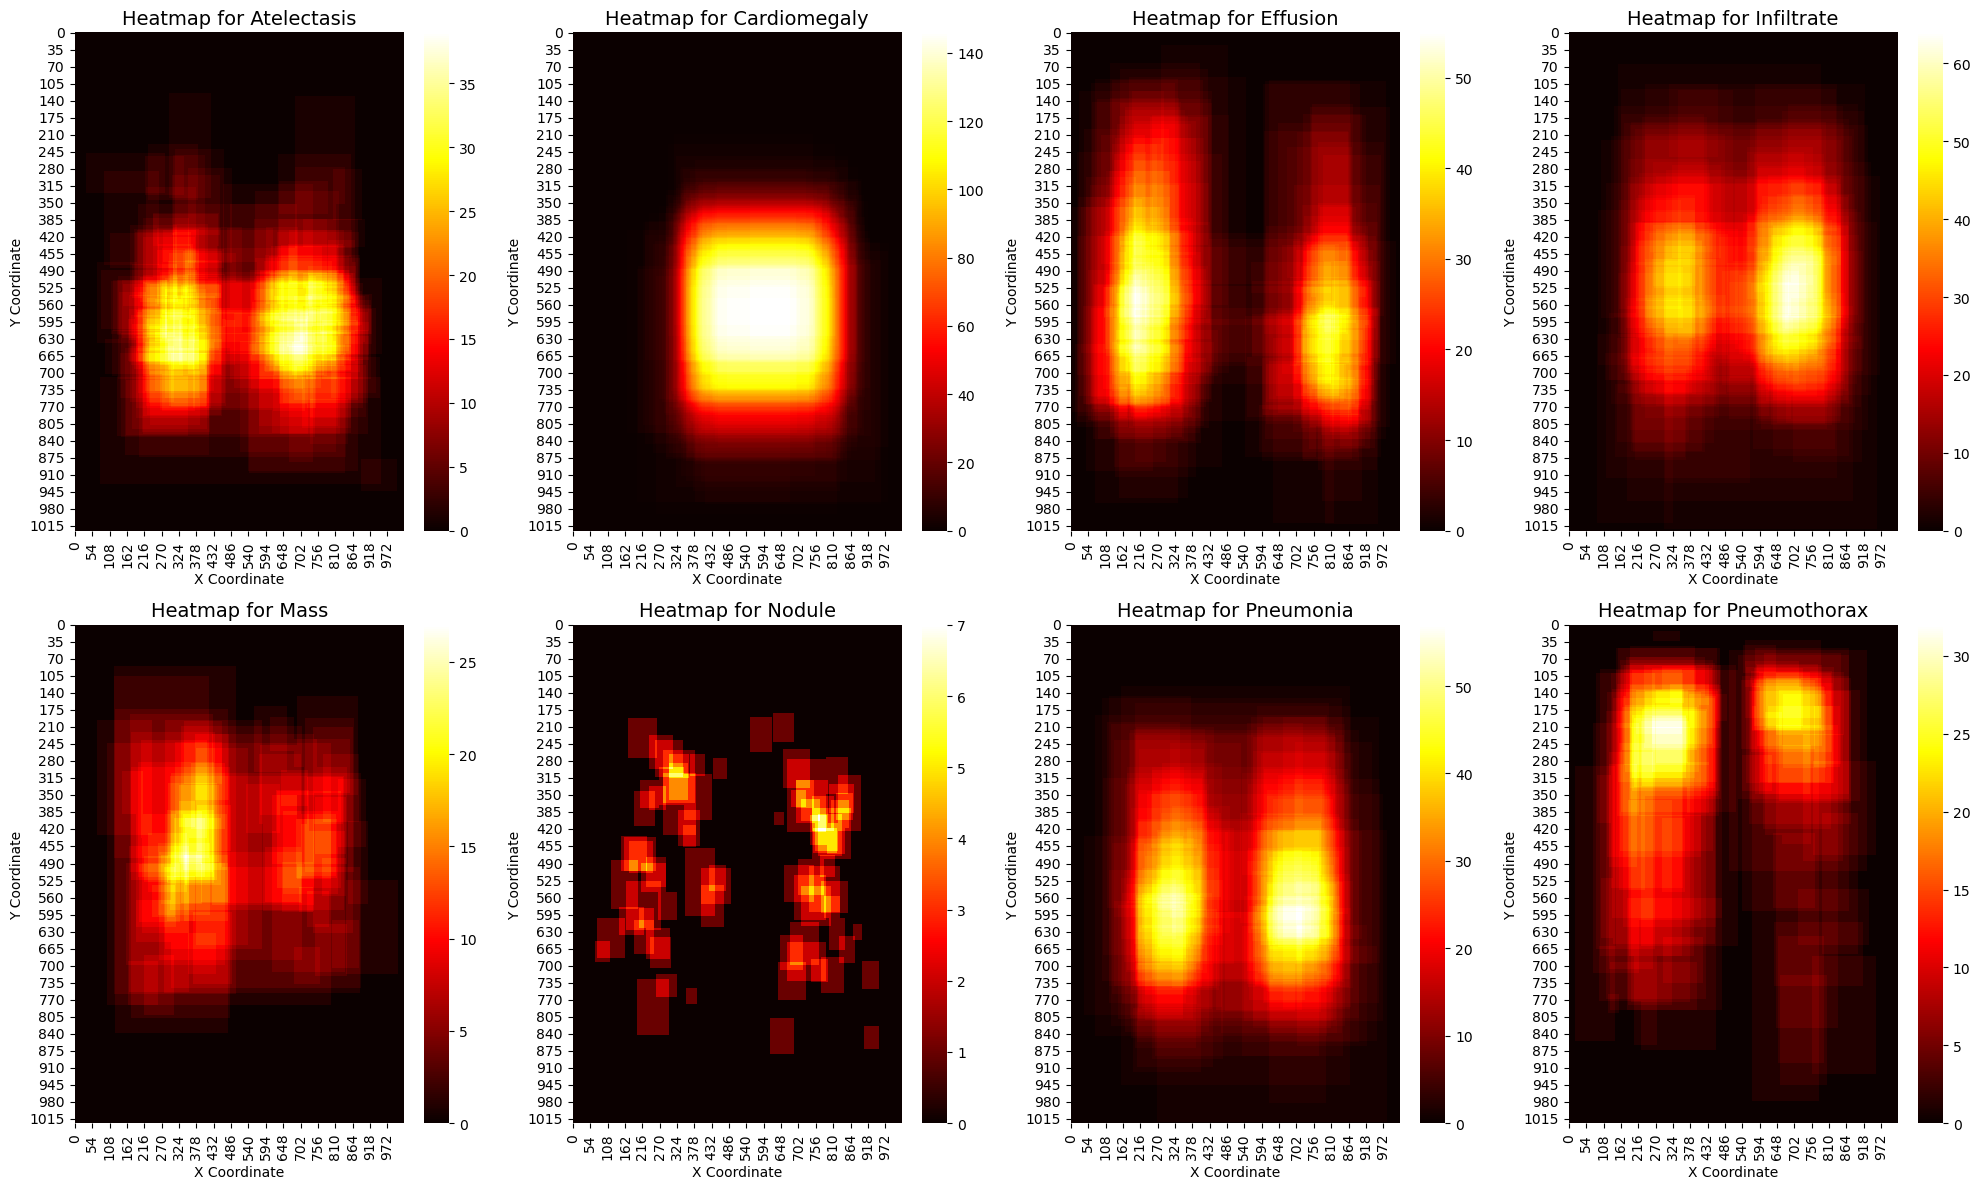

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming core8_labels is defined and heatmaps dictionary contains data for each label

# Number of labels to plot (core8 suggests 8 labels)
num_labels = len(core8_labels)

# Create a 2x4 grid for the 8 heatmaps
fig, axes = plt.subplots(2, 4, figsize=(20, 12))  # 2 rows, 4 columns

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot heatmaps for each label
for i, label in enumerate(core8_labels):
    sns.heatmap(heatmaps[label], cmap="hot", ax=axes[i], cbar=True)
    axes[i].set_title(f"Heatmap for {label}", fontsize=14)
    axes[i].set_xlabel("X Coordinate", fontsize=10)
    axes[i].set_ylabel("Y Coordinate", fontsize=10)

# Adjust layout to prevent overlapping of titles and labels
plt.tight_layout()
plt.show()

## Co-ocurrence matrix of the labels

In [24]:
import networkx as nx

# Step 1: Initialize an empty co-occurrence matrix
co_occurrence_matrix = pd.DataFrame(0, index=positive_labels, columns=positive_labels)

# Step 2: Compute co-occurrences between labels
for i in range(len(train_metadata)):
    # Get all labels present for the current patient (i.e., where one-hot encoding is 1)
    present_labels = train_metadata.iloc[i][positive_labels].index[train_metadata.iloc[i][positive_labels] == 1].tolist()
    
    # Update the co-occurrence matrix for every pair of present labels
    for label1 in present_labels:
        for label2 in present_labels:
            if label1 != label2:
                co_occurrence_matrix.loc[label1, label2] += 1


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
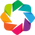

:Chord   [source,target]   (weight,edge_width)

In [25]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

edges = []
max_value = co_occurrence_matrix.max().max() 
for label1 in co_occurrence_matrix.index:
    for label2 in co_occurrence_matrix.columns:
        if co_occurrence_matrix.loc[label1, label2] > 0:
            edges.append((label1, label2, co_occurrence_matrix.loc[label1, label2],(co_occurrence_matrix.loc[label1, label2]/max_value)*10))

chord_data = pd.DataFrame(edges, columns=['source', 'target', 'weight', 'edge_width'])

chord = hv.Chord(chord_data)

chord.opts(
    opts.Chord(
        cmap='Category20',
        edge_cmap='Category20',
        edge_color='source',
        edge_line_width='edge_width',
        labels='index',
        node_size=15,
        edge_alpha=0.5,
        node_color='index',
        title="Co-Occurrence Chord Diagram of Positive Labels",
        height=800, width=800
    )
)

# Display the chord diagram
chord